In [58]:
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim
import os
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset

In [30]:
class SphereDataset(Dataset):
    def __init__(self, csv_path, images_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        input_vec = []
        input_vec.extend(eval(row['model_translation']))
        input_vec.extend(eval(row['material_diffuse']))
        input_vec.append(float(row['material_shininess']))
        input_vec.extend(eval(row['light_position']))
        input_vec = np.array(input_vec, dtype=np.float32)

        # Obraz wyjściowy
        img_path = os.path.join(self.images_dir, f"image_{int(row['frame']):04}.png")
        image = Image.open(img_path).convert("RGB").resize((128, 128))

        if self.transform:
            image = self.transform(image)

        return torch.tensor(input_vec), image

In [37]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

dataset = SphereDataset("src/data_fixed.csv", "output", transform=transform)

In [38]:
dataset[0]

(tensor([ -6.0000,   8.0000, -20.0000,   0.0863,   0.1137,   0.9686,  10.0000,
           9.0000,   1.0000,  10.0000]),
 tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1

## GAN

In [52]:
class Generator(nn.Module):
    def __init__(self, input_dim=10, img_size=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * 16 * 16),
            nn.ReLU(),
            nn.Unflatten(1, (128, 16, 16)),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),    # 128x128
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [51]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

## Trening

In [65]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [66]:
loader = DataLoader(dataset, batch_size=16, shuffle=True)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

In [67]:
from tqdm import tqdm

EPOCHS = 50

for epoch in range(EPOCHS):
    for batch_idx, (inputs, real_imgs) in tqdm(enumerate(loader)):
        inputs = inputs.to(device)
        real_imgs = real_imgs.to(device)
        valid = torch.ones(inputs.size(0), 1).to(device)
        fake = torch.zeros(inputs.size(0), 1).to(device)

        optimizer_G.zero_grad()
        gen_imgs = generator(inputs).to(device)
        validity = discriminator(gen_imgs).to(device)
        g_loss = criterion(validity, valid)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"[{epoch}] G_loss: {g_loss.item():.4f} | D_loss: {d_loss.item():.4f}")


26it [00:01, 21.71it/s]


[0] G_loss: 3.7634 | D_loss: 0.0133


26it [00:00, 27.58it/s]


[1] G_loss: 6.5409 | D_loss: 0.0007


26it [00:03,  7.19it/s]


[2] G_loss: 9.0791 | D_loss: 0.0001


26it [00:00, 27.36it/s]


[3] G_loss: 9.4162 | D_loss: 0.0000


26it [00:00, 27.49it/s]


[4] G_loss: 4.2771 | D_loss: 0.0070


26it [00:00, 27.54it/s]


[5] G_loss: 9.3755 | D_loss: 0.0000


26it [00:00, 27.49it/s]


[6] G_loss: 9.4624 | D_loss: 0.0000


26it [00:00, 27.40it/s]


[7] G_loss: 9.7427 | D_loss: 0.0000


26it [00:00, 27.35it/s]


[8] G_loss: 12.5886 | D_loss: 0.0000


26it [00:00, 27.26it/s]


[9] G_loss: 7.4767 | D_loss: 0.0003


26it [00:00, 27.47it/s]


[10] G_loss: 8.6126 | D_loss: 0.0001


26it [00:00, 27.42it/s]


[11] G_loss: 9.1881 | D_loss: 0.0001


26it [00:00, 27.30it/s]


[12] G_loss: 9.5394 | D_loss: 0.0000


26it [00:00, 27.57it/s]


[13] G_loss: 9.8039 | D_loss: 0.0000


26it [00:00, 27.44it/s]


[14] G_loss: 10.0177 | D_loss: 0.0000


26it [00:00, 27.43it/s]


[15] G_loss: 10.2027 | D_loss: 0.0000


26it [00:00, 27.68it/s]


[16] G_loss: 10.3640 | D_loss: 0.0000


26it [00:00, 27.49it/s]


[17] G_loss: 10.5079 | D_loss: 0.0000


26it [00:00, 27.51it/s]


[18] G_loss: 10.6382 | D_loss: 0.0000


26it [00:00, 27.49it/s]


[19] G_loss: 10.7430 | D_loss: 0.0000


26it [00:00, 27.34it/s]


[20] G_loss: 10.7124 | D_loss: 0.0000


26it [00:00, 27.39it/s]


[21] G_loss: 10.7173 | D_loss: 0.0000


26it [00:00, 27.31it/s]


[22] G_loss: 10.5010 | D_loss: 0.0000


26it [00:00, 27.68it/s]


[23] G_loss: 10.6324 | D_loss: 0.0000


26it [00:00, 27.51it/s]


[24] G_loss: 10.7403 | D_loss: 0.0000


26it [00:00, 27.54it/s]


[25] G_loss: 10.8689 | D_loss: 0.0000


26it [00:00, 27.49it/s]


[26] G_loss: 10.9923 | D_loss: 0.0000


26it [00:00, 27.60it/s]


[27] G_loss: 11.1063 | D_loss: 0.0000


26it [00:00, 27.59it/s]


[28] G_loss: 11.2164 | D_loss: 0.0000


26it [00:00, 27.41it/s]


[29] G_loss: 11.3187 | D_loss: 0.0000


26it [00:00, 27.36it/s]


[30] G_loss: 11.4226 | D_loss: 0.0000


26it [00:00, 27.46it/s]


[31] G_loss: 11.5035 | D_loss: 0.0000


26it [00:00, 27.53it/s]


[32] G_loss: 11.5854 | D_loss: 0.0000


26it [00:00, 27.36it/s]


[33] G_loss: 11.6757 | D_loss: 0.0000


26it [00:00, 27.39it/s]


[34] G_loss: 11.7428 | D_loss: 0.0000


26it [00:03,  7.17it/s]


[35] G_loss: 11.8145 | D_loss: 0.0000


26it [00:00, 27.12it/s]


[36] G_loss: 11.8832 | D_loss: 0.0000


26it [00:00, 27.37it/s]


[37] G_loss: 11.9433 | D_loss: 0.0000


26it [00:00, 27.28it/s]


[38] G_loss: 12.0147 | D_loss: 0.0000


26it [00:00, 27.45it/s]


[39] G_loss: 12.0679 | D_loss: 0.0000


26it [00:00, 27.44it/s]


[40] G_loss: 12.1220 | D_loss: 0.0000


26it [00:00, 27.19it/s]


[41] G_loss: 12.1786 | D_loss: 0.0000


26it [00:00, 27.43it/s]


[42] G_loss: 12.2314 | D_loss: 0.0000


26it [00:00, 27.43it/s]


[43] G_loss: 12.2907 | D_loss: 0.0000


26it [00:00, 27.35it/s]


[44] G_loss: 12.3489 | D_loss: 0.0000


26it [00:00, 27.34it/s]


[45] G_loss: 12.3817 | D_loss: 0.0000


26it [00:00, 27.52it/s]


[46] G_loss: 12.4136 | D_loss: 0.0000


26it [00:00, 27.45it/s]


[47] G_loss: 12.4661 | D_loss: 0.0000


26it [00:00, 27.41it/s]


[48] G_loss: 12.5066 | D_loss: 0.0000


26it [00:00, 27.58it/s]

[49] G_loss: 12.5591 | D_loss: 0.0000


In [57]:
def generate_random_input():
    model_translation = np.random.uniform(-20, 20, 3)
    material_diffuse = np.random.uniform(0, 255, 3) / 255.0
    material_shininess = np.random.uniform(3, 20, 1)
    light_position = np.random.uniform(-20, 20, 3)
    input_vec = np.concatenate([model_translation, material_diffuse, material_shininess, light_position]).astype(np.float32)
    return torch.tensor(input_vec)

tensor([ -0.5704,  -4.2577, -13.5037,   0.0333,   0.0405,   0.2837,  14.9839,
         -4.3525,  18.9624,  19.7536])


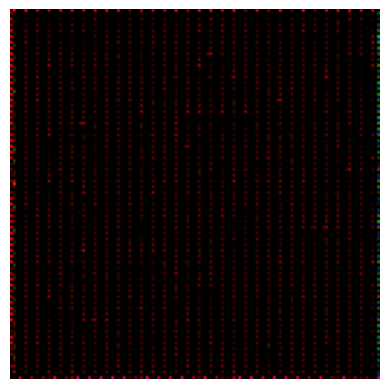

In [80]:
input_tensor = generate_random_input()
print(input_tensor)

with torch.no_grad():
    generated_img = generator(input_tensor.to(device).unsqueeze(0))
    generated_img = generated_img.squeeze(0)

img_np = generated_img.cpu().detach().numpy().transpose(1, 2, 0)

plt.imshow(img_np)
plt.axis('off')
plt.show()